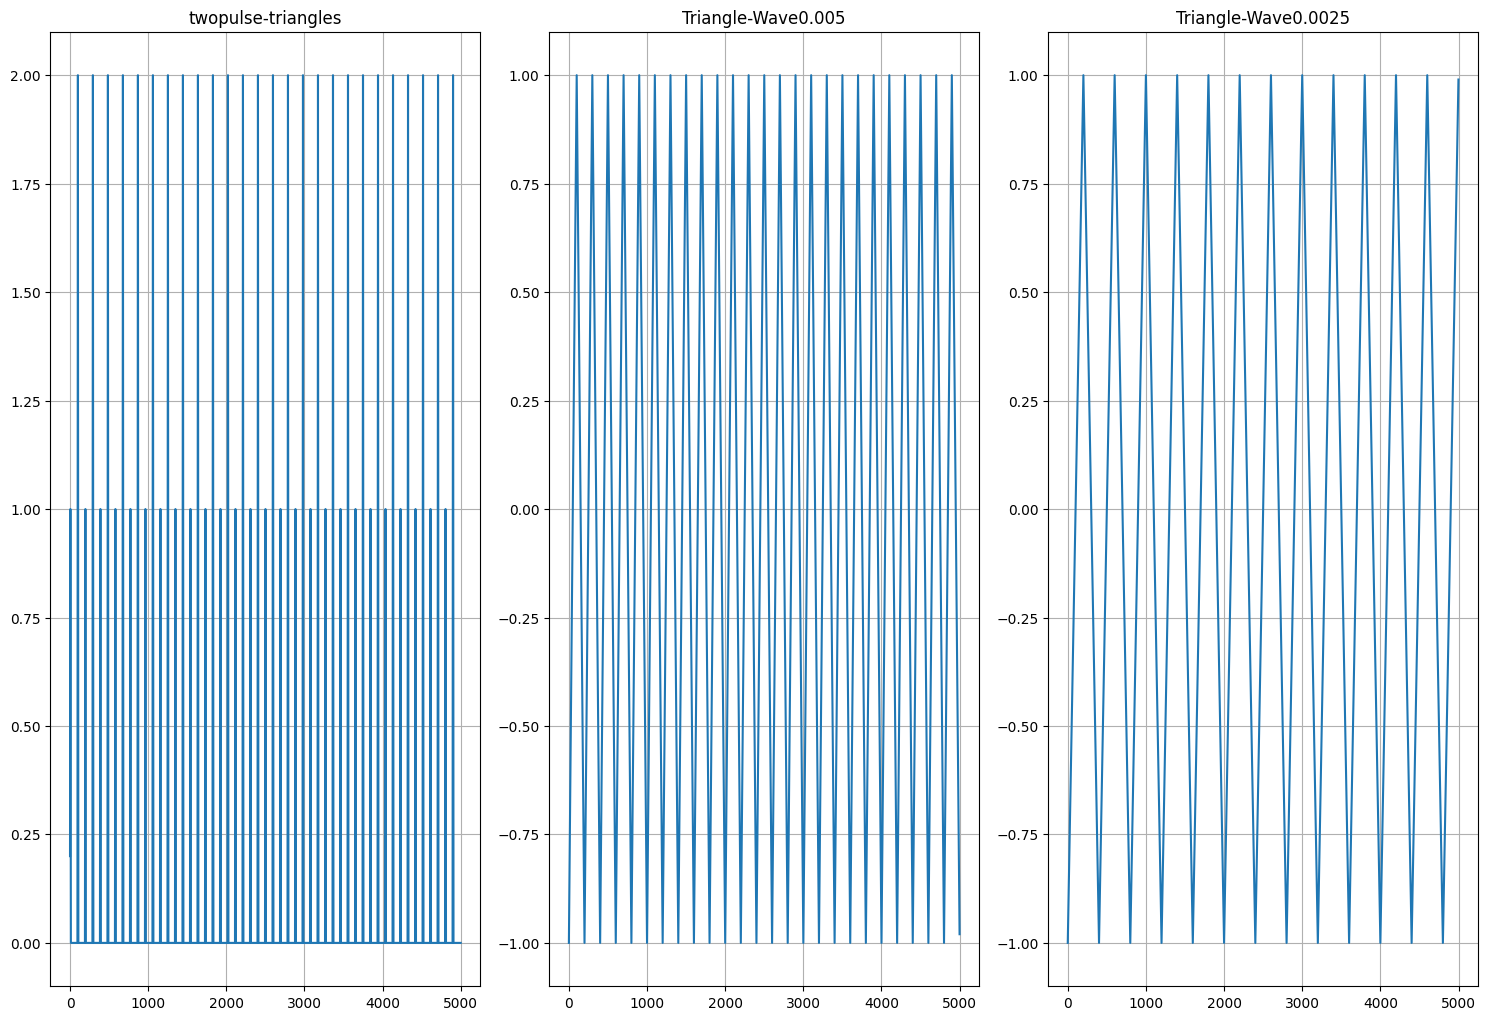

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.tsa.arima_process import ArmaProcess
import pandas as pd

# Signal generation functions
def generate_linear_signal(n, slope=10, intercept=0):
    x = np.arange(n)
    return slope * x + intercept

def generate_quadratic_signal(n, a=1, b=1, c=1):
    x = np.arange(n)
    return a * x ** 2 + b * x + c

def generate_exponential_signal(n, rate=0.01, a=1):
    x = np.arange(n)
    return a*np.exp(rate * x) + 1

def generate_logarithmic_signal(n, base=2):
    x = np.arange(1, n + 1)
    return np.log(x) / np.log(base)

def generate_logistic_signal(n, L=1, k=0.1, t0=None):
    """
    Generate a logistic (sigmoid) function signal representing S-shaped growth.
    
    Parameters:
    n (int): Length of the signal
    L (float): The curve's maximum value
    k (float): The growth rate or steepness of the curve
    t0 (float): The time of the sigmoid's midpoint (defaults to n/2)
    """
    if t0 is None:
        t0 = n / 2
        
    x = np.arange(n)
    return L / (1 + np.exp(-k * (x - t0)))

def generate_gompertz_signal(n, a=1, b=2, k=0.1):
    """
    Generate a Gompertz function signal, used in biology and economics.
    
    Parameters:
    n (int): Length of the signal
    a (float): The asymptotic value
    b (float): Displacement along the x-axis
    k (float): Growth rate
    """
    x = np.arange(n)
    return a * np.exp(-b * np.exp(-k * x))

def generate_power_law_signal(n, a=1, b=0.5):
    """
    Generate a power law signal for scaling relationships.
    
    Parameters:
    n (int): Length of the signal
    a (float): Scale parameter
    b (float): Power exponent
    """
    x = np.arange(1, n + 1)  # Avoid x=0 if b<0
    return a * x**b

def generate_step_signal(n, t0=None, c=0, d=1):
    """
    Generate a step function signal representing a sudden change.
    
    Parameters:
    n (int): Length of the signal
    t0 (int): Step transition point (defaults to n/2)
    c (float): Value before step
    d (float): Value after step
    """
    if t0 is None:
        t0 = n // 2
        
    signal = np.ones(n) * c
    signal[t0:] = d
    return signal

def generate_piecewise_linear_signal(n, breakpoints, values):
    """
    Generate a piecewise linear signal with specified values at breakpoints.
    
    Parameters:
    n (int): Length of the signal
    breakpoints (list): List of x-indices where values are specified
    values (list): List of y-values at the breakpoints
    """
    assert len(breakpoints) == len(values), "Number of breakpoints must equal number of values"
    
    # Add endpoints if not present
    if 0 not in breakpoints:
        breakpoints = [0] + list(breakpoints)
        values = [values[0]] + list(values)
    if n-1 not in breakpoints:
        breakpoints = list(breakpoints) + [n-1]
        values = list(values) + [values[-1]]
    
    # Sort by breakpoints
    bp_values = sorted(zip(breakpoints, values))
    sorted_bp = [bp for bp, _ in bp_values]
    sorted_values = [val for _, val in bp_values]
    
    # Create signal using linear interpolation
    signal = np.zeros(n)
    for i in range(len(sorted_bp) - 1):
        start_idx = sorted_bp[i]
        end_idx = sorted_bp[i + 1]
        start_val = sorted_values[i]
        end_val = sorted_values[i + 1]
        
        # Linear interpolation
        if end_idx > start_idx:
            for j in range(start_idx, end_idx + 1):
                t = (j - start_idx) / (end_idx - start_idx)
                signal[j] = (1 - t) * start_val + t * end_val
    
    return signal

def generate_alternating_triangle_pulses(n, small_amplitude=1, large_amplitude=2, width=40, interval=96):
    """
    Generate a time series with alternating triangle pulses (small peak, large peak).
    
    Parameters:
    n (int): Length of the signal
    small_amplitude (float): Amplitude of the smaller triangle pulse
    large_amplitude (float): Amplitude of the larger triangle pulse
    width (int): Width of each triangle pulse (should be even for symmetry)
    interval (int): Interval between consecutive triangle pulses
    
    Returns:
    numpy.ndarray: The generated signal
    """
    # Create a time series of zeros
    signal = np.zeros(n)
    
    # Ensure width is even for symmetric triangles
    if width % 2 != 0:
        width += 1
    
    # Determine how many triangle pulses we can fit
    num_triangles = (n - 1) // interval + 1
    
    # Add alternating triangle pulses
    for i in range(num_triangles):
        # Position of the current triangle pulse
        pos = i * interval
        
        # Check if we still have room for the triangle
        if pos + width > n:
            break
        
        # Determine amplitude (alternating small and large)
        amplitude = small_amplitude if i % 2 == 0 else large_amplitude
        
        # Create a triangle pulse
        half_width = width // 2
        for j in range(width):
            if j < half_width:
                # Rising part of the triangle
                value = amplitude * (j + 1) / half_width
            else:
                # Falling part of the triangle
                value = amplitude * (width - j) / half_width
            
            if pos + j < n:  # Ensure we don't go beyond array bounds
                signal[pos + j] = value
    
    return signal

def generate_gaussian_signal(n, a=1, t0=None, sigma=None):
    """
    Generate a Gaussian (bell curve) signal.
    
    Parameters:
    n (int): Length of the signal
    a (float): Peak amplitude
    t0 (float): Center position (defaults to n/2)
    sigma (float): Standard deviation (defaults to n/10)
    """
    if t0 is None:
        t0 = n / 2
    if sigma is None:
        sigma = n / 10
        
    x = np.arange(n)
    return a * np.exp(-((x - t0)**2) / (2 * sigma**2))

def generate_sine_wave(n, amplitude=1, frequency=0.5, phase=0):
    x = np.arange(n)
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)

def generate_composite_sine(n, components):
    """
    Generate a signal composed of multiple sine waves.
    
    Parameters:
    n (int): Length of the signal
    components (list): List of tuples, each containing (amplitude, frequency, phase_shift, wave_type)
                      where wave_type is 'sin' or 'cos' (defaults to 'sin' if not specified)
    
    Returns:
    numpy.ndarray: The composite signal
    """
    x = np.arange(n)
    signal = np.zeros(n)
    
    for component in components:
        if len(component) == 3:
            amplitude, frequency, phase_shift = component
            wave_type = 'sin'
        elif len(component) == 4:
            amplitude, frequency, phase_shift, wave_type = component
        else:
            raise ValueError("Each component must be a tuple of (amplitude, frequency, phase_shift) or (amplitude, frequency, phase_shift, wave_type)")
        
        if wave_type.lower() == 'sin':
            signal += amplitude * np.sin(2 * np.pi * frequency * x + phase_shift)
        elif wave_type.lower() == 'cos':
            signal += amplitude * np.cos(2 * np.pi * frequency * x + phase_shift)
        else:
            raise ValueError("wave_type must be 'sin' or 'cos'")
            
    return signal

def generate_cosine_wave(n, amplitude=1, frequency=0.5, phase=0):
    x = np.arange(n)
    return amplitude * np.cos(2 * np.pi * frequency * x + phase)

def generate_triangle_wave(n, amplitude=1, frequency=0.5):
    return amplitude * signal.sawtooth(2 * np.pi * frequency * np.arange(n), 0.5)

def generate_sawtooth_wave(n, amplitude=1, frequency=0.1, phase_shift=0.99):
    """
    Generate a sawtooth wave with consistent peak values.
    
    Parameters:
    n (int): Length of the signal
    amplitude (float): Peak amplitude of the wave
    frequency (float): Frequency of the wave
    phase_shift (float): Phase shift to align peaks with sample points (0-1)
    """
    # Phase shift ensures peaks align with discrete sample points
    return amplitude * signal.sawtooth(2 * np.pi * frequency * np.arange(n) + phase_shift * np.pi)

def generate_square_wave(n, amplitude=1, frequency=0.5):
    return amplitude * signal.square(2 * np.pi * frequency * np.arange(n))

def generate_sinc_wave(n, amplitude=1, frequency=1.0):
    """
    Generate a sinc wave (sin(x)/x)
    
    Parameters:
    n (int): Length of the signal
    amplitude (float): Amplitude of the wave
    frequency (float): Controls how quickly the sinc function decays (smaller = slower decay)
    """
    # Scale the range by frequency to control decay rate
    x = np.linspace(-8 * np.pi / frequency, 8 * np.pi / frequency, n)
    # Using numpy's sinc function (defined as sin(πx)/(πx))
    return amplitude * np.sinc(x / np.pi)

# Noise addition functions
def add_noise_by_snr(signal, snr_db=20):
    """Add Gaussian noise based on signal-to-noise ratio (SNR in dB)"""
    signal_power = np.var(signal)  # Signal power (variance)
    snr_linear = 10 ** (snr_db / 10)  # Convert dB to linear scale
    noise_variance = signal_power / snr_linear  # Noise variance = signal power / SNR
    noise = np.random.normal(0, np.sqrt(noise_variance), len(signal))
    return signal + noise

def add_poisson_noise(signal):
    """Add Poisson noise (signal must be non-negative)"""
    # Shift signal to non-negative (if original signal contains negative values)
    offset = np.min(signal)
    if offset < 0:
        signal_shifted = signal - offset
    else:
        signal_shifted = signal
    
    # Poisson noise variance equals the mean, so no SNR calculation needed
    noisy_signal = np.random.poisson(np.maximum(signal_shifted, 0))  # Ensure non-negative
    
    # Restore original signal offset
    if offset < 0:
        noisy_signal = noisy_signal + offset
    return noisy_signal

def add_point_anomalies(signal, anomaly_ratio=0.05, base_amplitude_range=(0.1, 0.3), debug=False):
    """
    Add point anomalies with amplitude adaptively adjusted based on signal range
    
    Parameters:
    signal: input signal
    anomaly_ratio: proportion of anomalous points in total data
    base_amplitude_range: base anomaly amplitude range (adjusted based on signal range)
    debug: whether to print debug information
    """
    signal_range = np.max(signal) - np.min(signal)
    signal_length = len(signal)
    train_length = int(signal_length * 0.8)  # Only add anomalies in the first 80% of data
    num_anomalies = int(train_length * anomaly_ratio)
    
    # Adjust anomaly amplitude based on signal range
    if signal_range > 100:
        adjusted_amplitude_range = (base_amplitude_range[0] * 0.2, base_amplitude_range[1] * 0.2)
    elif signal_range < 4:
        adjusted_amplitude_range = (base_amplitude_range[0] * 2, base_amplitude_range[1] * 2)
    else:
        adjusted_amplitude_range = base_amplitude_range
    
    # Print debug information if requested
    if debug:
        print(f"Signal range: {signal_range}")
        print(f"Adjusted anomaly amplitude range: {adjusted_amplitude_range[0] * signal_range} to {adjusted_amplitude_range[1] * signal_range}")
    
    # Randomly select anomaly positions (only in first 80% of data)
    anomaly_positions = np.random.choice(train_length, num_anomalies, replace=False)
    
    # Generate anomalous signal
    anomalous_signal = signal.copy()
    for pos in anomaly_positions:
        sign = np.random.choice([-1, 1])
        amplitude = np.random.uniform(adjusted_amplitude_range[0], adjusted_amplitude_range[1]) * signal_range
        anomalous_signal[pos] += sign * amplitude
    
    return anomalous_signal

def add_pulse_anomalies(signal, num_pulses=3, pulse_width_range=(10, 30), base_amplitude_range=(0.1, 0.3), debug=False):
    """
    Add pulse anomalies with amplitude adaptively adjusted based on signal range
    
    Parameters:
    signal: input signal
    num_pulses: number of pulses
    pulse_width_range: range of pulse widths (sample points)
    base_amplitude_range: base anomaly amplitude range (adjusted based on signal range)
    debug: whether to print debug information
    """
    signal_range = np.max(signal) - np.min(signal)
    signal_length = len(signal)
    train_length = int(signal_length * 0.8)  # Only add anomalies in the first 80% of data
    
    # Adjust anomaly amplitude based on signal range
    if signal_range > 100:
        adjusted_amplitude_range = (base_amplitude_range[0] * 0.8, base_amplitude_range[1] * 0.8)
    elif signal_range < 4:
        adjusted_amplitude_range = (base_amplitude_range[0] * 2, base_amplitude_range[1] * 2)
    else:
        adjusted_amplitude_range = base_amplitude_range
    
    # Print debug information if requested
    if debug:
        print(f"Signal range: {signal_range}")
        print(f"Adjusted pulse amplitude range: {adjusted_amplitude_range[0] * signal_range} to {adjusted_amplitude_range[1] * signal_range}")
    
    anomalous_signal = signal.copy()
    
    # Ensure sufficient spacing between pulses, but only in first 80% of data
    min_distance = max(pulse_width_range[1], train_length // (num_pulses * 2))
    
    # Generate non-overlapping pulse positions
    possible_positions = list(range(0, train_length - pulse_width_range[1]))
    pulse_positions = []
    for _ in range(num_pulses):
        while possible_positions:
            pos = np.random.choice(possible_positions)
            if not any(abs(pos - p) < min_distance for p in pulse_positions):
                pulse_positions.append(pos)
                possible_positions = [p for p in possible_positions 
                                   if abs(p - pos) >= min_distance]
                break
            if len(possible_positions) == 0:
                break
    
    # Add pulses
    for pos in pulse_positions:
        width = np.random.randint(pulse_width_range[0], pulse_width_range[1])
        sign = np.random.choice([-1, 1])
        amplitude = np.random.uniform(adjusted_amplitude_range[0], adjusted_amplitude_range[1]) * signal_range
        anomalous_signal[pos:pos+width] += sign * amplitude
    
    return anomalous_signal

# Save signal to file
def save_signal(signal, folder, signal_name, dataset_id=None, category=None, length=None):
    """
    Save signal to CSV file using a flat folder structure
    First column is timestamp, second column is signal value
    """
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Build new filename format
    filename = signal_name
    if dataset_id is not None:
        filename = f"dataset{dataset_id}_{filename}"
    if category is not None:
        filename = f"{filename}_{category}"
    if length is not None:
        filename = f"{filename}_length{length}"
    
    # Create timestamp column (simple sequence number)
    timestamps = np.arange(len(signal))
    
    # Save data as CSV file
    df = pd.DataFrame({
        'date': timestamps,
        'Feature1': signal
    })
    
    df.to_csv(os.path.join(folder, f"{filename}.csv"), index=False)

# Visualize multiple signals
def plot_signals(signal_data_dict, figsize=(15, 20)):
    plt.figure(figsize=figsize)
    for i, (name, signal) in enumerate(signal_data_dict.items()):
        plt.subplot(len(signal_data_dict) // 3 + 1, 3, i + 1)
        plt.plot(signal)
        plt.title(name)
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main program
def generate_and_save_datasets(seed, dataset_folder, dataset_id):
    n = 5000  # Signal length
    np.random.seed(seed)  # Set random seed

    signal_generators = {
        "twopulse-triangles": lambda: generate_alternating_triangle_pulses(n, 1, 2, 10, 96),
        "Triangle-Wave0.005": lambda: generate_triangle_wave(n, amplitude=1, frequency=0.005),
        "Triangle-Wave0.0025": lambda: generate_triangle_wave(n, amplitude=1, frequency=0.0025),
    }

    # 1. Generate raw datasets and save
    signal_data_dict = {}
    for signal_name, generator in signal_generators.items():
        signal_data = generator()
        signal_data_dict[signal_name] = signal_data
        save_signal(signal_data, dataset_folder, signal_name, dataset_id=dataset_id, category="raw", length=n)

    # Visualize raw signals
    plot_signals(signal_data_dict)

def generate_multiple_datasets(num_datasets=5):
    output_folder = "Dataset_generated_longdistance"  
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for i in range(num_datasets):
        seed = i + 42  # Better seed initialization
        generate_and_save_datasets(seed, output_folder, i+1)

if __name__ == "__main__":
    generate_multiple_datasets(num_datasets=1)